In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm

os.chdir('..')

In [2]:
subject_id = 3
trial_id = 1

eeg_clean_path = f"./Generated/Data/S_{subject_id}/Trial_{trial_id}/EEG_clean.fif"
experiment_path = f"./Generated/Data/S_{subject_id}/Trial_{trial_id}/Experiment.json"

# Load the .fif file
raw = mne.io.read_raw_fif(eeg_clean_path , preload=True, verbose=False)
raw.pick_types(eeg=True, verbose=False)  # только EEG-каналы
sr = int(raw.info['sfreq'])  # sampling rate

# Load experiment sequence
with open(experiment_path,'r') as f:
    experiment_seq = json.load(f)


/tmp/ipykernel_95013/2948111701.py:8: RuntimeWarning: This filename (./Generated/Data/S_3/Trial_1/EEG_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_clean_path , preload=True, verbose=False)


# All experiment spectrum
Get all the blocks except first 30 and 300 sec rest blocks, and plot the spectrum for all subjects.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


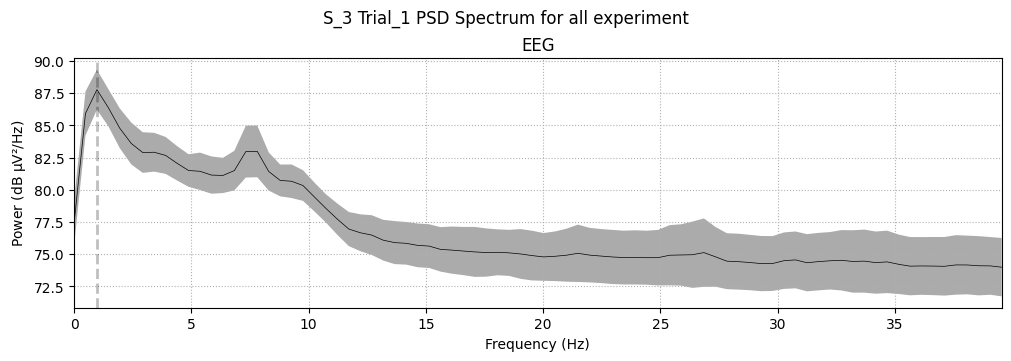

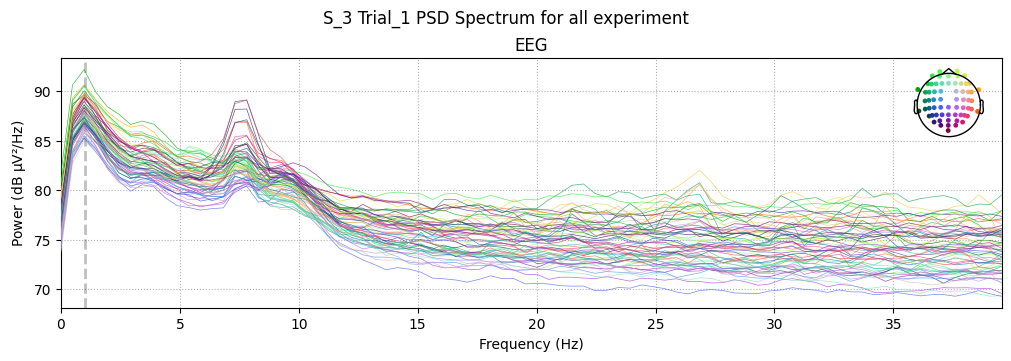

In [3]:
# Фильтруем все блоки кроме 300 sec и 30 sec rest
clean_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if not (block_data['type'] == 'rest' and (block_data['content']['duration'] == 300 or block_data['content']['duration'] == 30))
]

# Соберем отрезки с execution
epochs = []
for start_time, duration in clean_blocks:
    start_sample = int(start_time)
    stop_sample = min(int((start_time + duration)), len(raw) / sr - 0.001)
    segment = raw.copy().crop(tmin=start_sample, tmax=stop_sample)
    epochs.append(segment)

# Объединяем все execution-сегменты
raw = mne.concatenate_raws(epochs)

# Путь к выходной директории
out_dir = "./Generated/Figures/Spectral_Analysis/Temp"
os.makedirs(out_dir, exist_ok=True)

title = f"S_{subject_id} Trial_{trial_id} PSD Spectrum for all experiment"

# Рисуем усредненный PSD
fig1 = raw.plot_psd(fmax=40, average=True, show=False)
fig1.suptitle(title)
fig1.savefig(os.path.join(out_dir, f"S_{subject_id}_Trial_{trial_id}_PSD_All_avg.png"))

# Рисуем PSD для всего raw
fig2 = raw.plot_psd(fmax=40, show=False)
fig2.suptitle(title)
fig2.savefig(os.path.join(out_dir, f"S_{subject_id}_Trial_{trial_id}_PSD_All.png"))

plt.show()

# Опционально: закрываем фигуры чтобы освободить память
plt.close(fig1)
plt.close(fig2)

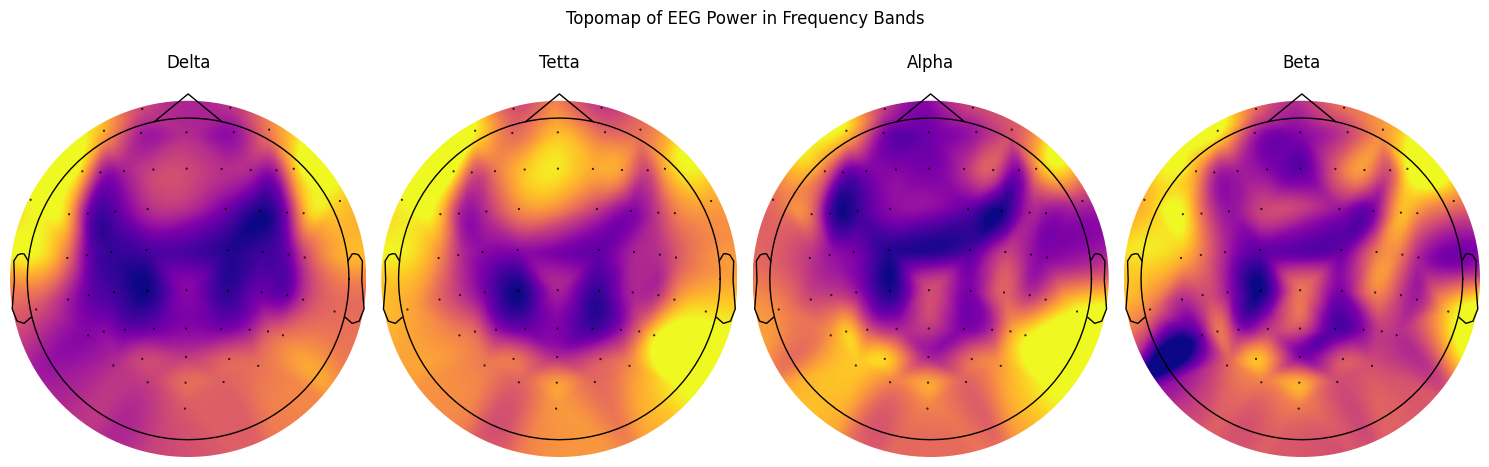

In [4]:
# Параметры PSD
psd = raw.compute_psd(fmin=1, fmax=40, n_fft=2048, verbose=False)
psds_data = 10 * np.log10(psd.get_data())  # [n_channels, n_freqs]
freqs = psd.freqs

# Усреднение по частотным диапазонам
band_limits = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Alpha': (7, 13),
    'Beta': (13, 30)
}

# Отрисовка топомап
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for ax, (band_name, (fmin_band, fmax_band)) in zip(axes, band_limits.items()):
    freq_mask = (freqs >= fmin_band) & (freqs <= fmax_band)
    psds_band = psds_data[:, freq_mask].mean(axis=1)

    vmin = np.min(psds_band)
    vmax = np.max(psds_band)

    mne.viz.plot_topomap(
        psds_band, raw.info, axes=ax, show=False,
        cmap='plasma', contours=0, vlim=(vmin, vmax)
    )
    ax.set_title(f'{band_name}')

plt.suptitle("Topomap of EEG Power in Frequency Bands")
plt.tight_layout()

out_dir = "./Generated/Figures/Spectral_Analysis/Temp/"

# Сохраняем график
fig.savefig(f"{out_dir}S_{subject_id}_Trial_{trial_id}_Freq_Bands_Local.png", dpi=100)

plt.show()
pass

# EEG to audio :)

In [ ]:
# from pydub import AudioSegment
# import numpy as np
# import soundfile as sf

# # Выбираем канал, например, 'Cz' или просто 0-й по индексу
# channel_index = 15  # можно изменить на нужный

# # Получаем данные из канала
# data, times = raw[channel_index, :]
# data = data[0]  # убираем лишнюю ось

# # Нормализуем до диапазона [-1, 1]
# data = data / np.max(np.abs(data))

# # Переводим в int16 для аудио
# audio_data = (data * 32767).astype(np.int16)

# # Временный WAV файл
# sf.write("temp.wav", audio_data, samplerate=44100)  # ресемпл, если нужно

# # Конвертируем WAV → MP3
# sound = AudioSegment.from_wav("temp.wav")
# sound.export("./eeg_channel.mp3", format="mp3")

# print("Сохранено в eeg_channel.mp3")

# Execution Vs Rest Blocks
TODO refactor

In [82]:
# Параметры
freq = 12  # Гц
times = np.arange(0, 100, 10)  # Каждые 10 секунд
fmin, fmax = freq - 1, freq + 1

# Подготовка графика
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, t_start in enumerate(times):
    t_end = t_start + 10
    raw_segment = raw.copy().crop(tmin=t_start, tmax=t_end)
    
    # Теперь psd_welch вызывается как метод объекта raw
    psds, freqs = raw_segment.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    
    # Усреднение по частотам
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    psds_band = psds[:, freq_mask].mean(axis=1)

    # Топомап
    mne.viz.plot_topomap(
        psds_band, raw.info, axes=axes[i], show=False,
        cmap='plasma', contours=0
    )
    axes[i].set_title(f'{t_start}-{t_end}s')

plt.title(f"{freq}Hz Frequency Localization")
plt.tight_layout()
plt.show()

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


KeyboardInterrupt: 

In [12]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Параметры
eeg_clean_path = "./Generated/Data/S_2/Trial_1/EEG_clean.fif"
output_dir = "./topomap_frames"
freq = 30
descretization = 0.3   # in seconds
duration = 300        # in seconds
times = np.arange(0, duration, descretization)
fmin, fmax = freq - 1, freq + 1
gif_path = "./topomap_30Hz.gif"

# Создание папки для кадров
os.makedirs(output_dir, exist_ok=True)

# Загрузка EEG
raw = mne.io.read_raw_fif(eeg_clean_path, preload=True)
raw.pick_types(eeg=True)

# Сначала получим min и max значений по всем окнам, чтобы зафиксировать цветовую шкалу
all_psds = []
for t_start in tqdm(times):
    t_end = t_start + 1
    raw_segment = raw.copy().crop(tmin=t_start, tmax=t_end)
    psds, freqs = raw_segment.compute_psd(fmin=fmin, fmax=fmax, verbose=False).get_data(return_freqs=True)
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    psds_band = psds[:, freq_mask].mean(axis=1)
    all_psds.append(psds_band)

all_psds = np.array(all_psds)
vmin = np.min(all_psds)
vmax = np.max(all_psds)

# Генерация топомапов с colorbar и фиксированной шкалой
frame_paths = []

for i, psds_band in enumerate(all_psds):
    t_start = times[i]
    t_end = t_start + descretization

    fig, ax = plt.subplots(figsize=(5, 4))
    im, _ = mne.viz.plot_topomap(
        psds_band, raw.info, axes=ax, show=False,
        cmap='plasma', contours=0, vlim=(vmin, vmax)
    )
    ax.set_title(f'{t_start}-{t_end}s')

    # Добавим colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.05)
    cbar.set_label('Power (a.u.)')

    frame_path = os.path.join(output_dir, f'frame_{i:02d}.png')
    plt.title(f"{freq}Hz Frequency Localization ({t_start:.2f} sec.)")
    fig.savefig(frame_path, dpi=100)
    plt.close(fig)
    frame_paths.append(frame_path)

# Создание GIF
images = [Image.open(p) for p in frame_paths]
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=1000/10, loop=0)    # 10fps

print(f"GIF сохранён: {gif_path}")

Opening raw data file ./Generated/Data/S_2/Trial_1/EEG_clean.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 63) active
    Range : 0 ... 1547999 =      0.000 ...  1547.999 secs
Ready.
Reading 0 ... 1547999  =      0.000 ...  1547.999 secs...


/tmp/ipykernel_24467/3160004034.py:21: RuntimeWarning: This filename (./Generated/Data/S_2/Trial_1/EEG_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_clean_path, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]


GIF сохранён: ./topomap_12Hz.gif


# Execution spectrum

[(153, 15), (181, 15), (209, 15), (237, 15), (265, 15), (293, 15), (321, 15), (759, 15), (787, 15), (815, 15), (843, 15), (871, 15), (899, 15), (927, 15), (1365, 15), (1393, 15), (1421, 15), (1449, 15), (1477, 15), (1505, 15), (1533, 15)]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


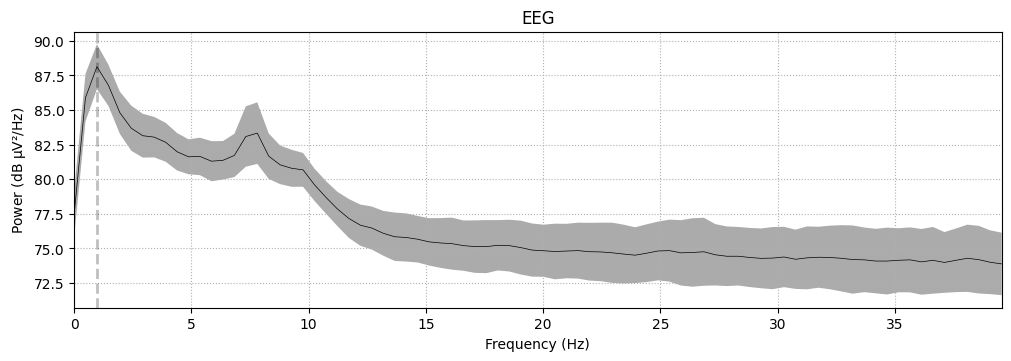

In [98]:
# Фильтруем execution-блоки
execution_blocks = [
    (block_data['timestamp'], block_data['content']['duration'], )
    for block_data in experiment_seq.values()
    if block_data['type'] == 'execution'
]

# execution_blocks = execution_blocks[14:21]

print(execution_blocks)

# Соберем отрезки с execution
execution_epochs = []
for start_time, duration in execution_blocks:
    start_sample = int(start_time)
    stop_sample = min(int((start_time + duration)), len(raw) / sr - 0.001)
    segment = raw.copy().crop(tmin=start_sample, tmax=stop_sample)
    execution_epochs.append(segment)

# Объединяем все execution-сегменты
raw_execution = mne.concatenate_raws(execution_epochs)

# Рисуем PSD
raw_execution.plot_psd(fmax=40, average=True)

[(168, 10), (196, 10), (224, 10), (252, 10), (280, 10), (308, 10), (774, 10), (802, 10), (830, 10), (858, 10), (886, 10), (914, 10), (1380, 10), (1408, 10), (1436, 10), (1464, 10), (1492, 10), (1520, 10)]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


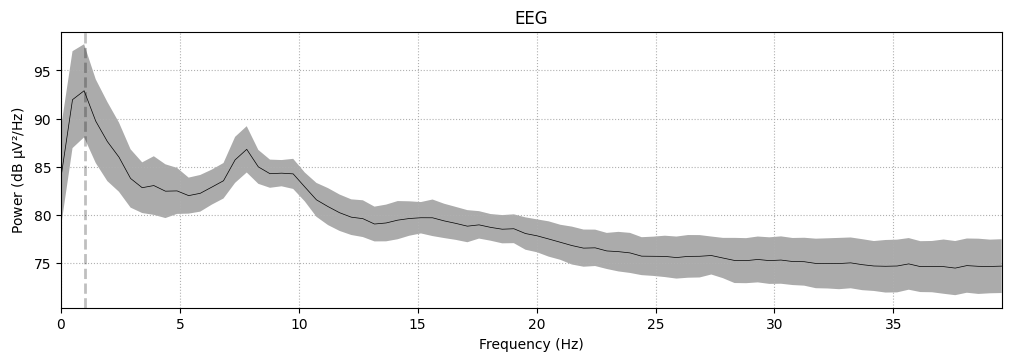

In [84]:
# Фильтруем execution-блоки
rest_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'rest' and block_data['content']['duration'] == 10
]

# rest_blocks = rest_blocks[12:18]
print(rest_blocks)

# Соберем отрезки с execution
execution_epochs = []
for start_time, duration in rest_blocks:
    start_sample = int(start_time)
    stop_sample = min(int((start_time + duration)), len(raw) / sr - 0.001)
    segment = raw.copy().crop(tmin=start_sample, tmax=stop_sample)
    execution_epochs.append(segment)

# Объединяем все execution-сегменты
raw_execution = mne.concatenate_raws(execution_epochs)

# Рисуем PSD
raw_execution.plot_psd(fmax=40, average=True)

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


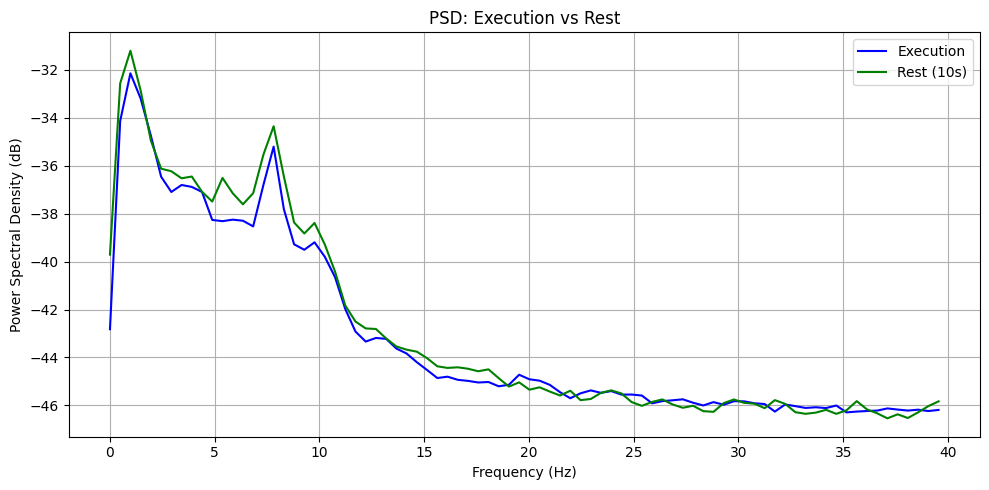

In [101]:
import mne
import matplotlib.pyplot as plt

i = 2

# Получаем частоту дискретизации
sr = raw.info['sfreq']

# --- Выбор блоков из experiment_seq ---
execution_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'execution'
]
execution_blocks = execution_blocks[i*7:i*7+7]

rest_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'rest' and block_data['content']['duration'] == 10
]
rest_blocks = rest_blocks[i*6:i*6+6]

# --- Выделяем execution EEG-сегменты ---
execution_segments = []
for start_time, duration in execution_blocks:
    tmin = start_time
    tmax = min(start_time + duration, raw.times[-1] - 0.001)
    segment = raw.copy().crop(tmin=tmin, tmax=tmax)
    execution_segments.append(segment)

raw_execution = mne.concatenate_raws(execution_segments)

# --- Выделяем rest EEG-сегменты ---
rest_segments = []
for start_time, duration in rest_blocks:
    tmin = start_time
    tmax = min(start_time + duration, raw.times[-1] - 0.001)
    segment = raw.copy().crop(tmin=tmin, tmax=tmax)
    rest_segments.append(segment)

raw_rest = mne.concatenate_raws(rest_segments)

# --- Вычисляем PSD ---
psd_exec = raw_execution.compute_psd(fmax=40, method='welch', average='mean')
psd_rest = raw_rest.compute_psd(fmax=40, method='welch', average='mean')

# --- График ---
freqs = psd_exec.freqs
mean_exec = psd_exec.get_data().mean(axis=0)
mean_rest = psd_rest.get_data().mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(freqs, 10 * np.log10(mean_exec), label='Execution', color='blue')
plt.plot(freqs, 10 * np.log10(mean_rest), label='Rest (10s)', color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD: Execution vs Rest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
pass

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective wind

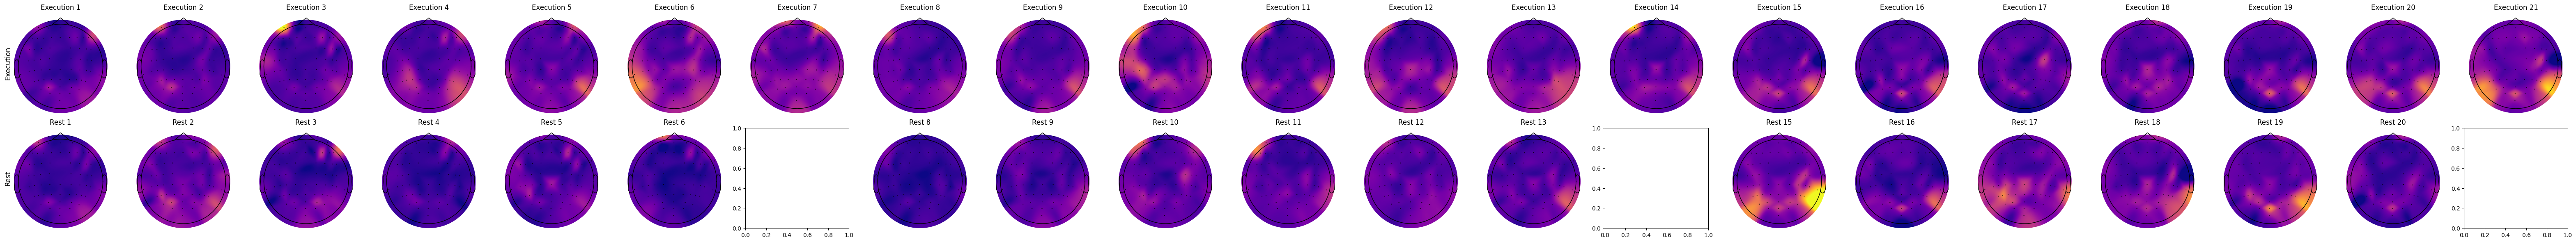

In [106]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Частота интереса

# ALPHA
target_freq = 10.5
tolerance = 2.5  # ширина окна вокруг целевой частоты

# # BETA
# target_freq = 27
# tolerance = 13  # ширина окна вокруг целевой частоты

# Подготовка списков блоков
execution_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'execution'
]

rest_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'rest' and block_data['content']['duration'] == 10
]

# Функция для получения топомапа по 12 Гц
def get_band_power_topo(raw_segment, freq, tol=0.5):
    psd = raw_segment.compute_psd(fmax=freq+tol+1, method='welch', average='mean')
    freqs = psd.freqs
    idx_band = np.where((freqs >= freq - tol) & (freqs <= freq + tol))[0]
    psd_data = psd.get_data()
    psd_band = psd_data[:, idx_band].mean(axis=1)  # среднее по диапазону
    return psd_band

# Вычисляем все топомапы
execution_topos = []
for start_time, duration in execution_blocks:
    tmin = start_time
    tmax = min(start_time + duration, raw.times[-1] - 0.001)
    segment = raw.copy().crop(tmin=tmin, tmax=tmax)
    topo = get_band_power_topo(segment, target_freq, tolerance)
    execution_topos.append(topo)

rest_topos = []
for start_time, duration in rest_blocks:
    tmin = start_time
    tmax = min(start_time + duration, raw.times[-1] - 0.001)
    segment = raw.copy().crop(tmin=tmin, tmax=tmax)
    topo = get_band_power_topo(segment, target_freq, tolerance)
    rest_topos.append(topo)

# Определим общий min/max для нормализации цветовой шкалы
all_topos = execution_topos + rest_topos
vmin = min([t.min() for t in all_topos])
vmax = max([t.max() for t in all_topos])

# Рисуем топомапы
n_exec = len(execution_topos)
n_rest = len(rest_topos)

fig, axes = plt.subplots(2, max(n_exec, n_rest), figsize=(3 * max(n_exec, n_rest), 6))

# Execution
for i, psds_band in enumerate(execution_topos):
    ax = axes[0, i] if n_exec > 1 else axes[0]
    mne.viz.plot_topomap(
        psds_band, raw.info, axes=ax, show=False,
        cmap='plasma', contours=0, vlim=(vmin, vmax)
    )
    ax.set_title(f'Execution {i+1}')

# Rest
for i, psds_band in enumerate(rest_topos):
    if i>=6:
        i+=1
        if i>=13:
            i+=1
    ax = axes[1, i] if n_rest > 1 else axes[1]
    mne.viz.plot_topomap(
        psds_band, raw.info, axes=ax, show=False,
        cmap='plasma', contours=0, vlim=(vmin, vmax)
    )
    ax.set_title(f'Rest {i+1}')

axes[0, 0].set_ylabel('Execution', fontsize=12)
axes[1, 0].set_ylabel('Rest', fontsize=12)
plt.tight_layout()
plt.savefig(f'{int(target_freq)}HZ_localization.png')
plt.show()